<Figure size 432x288 with 0 Axes>

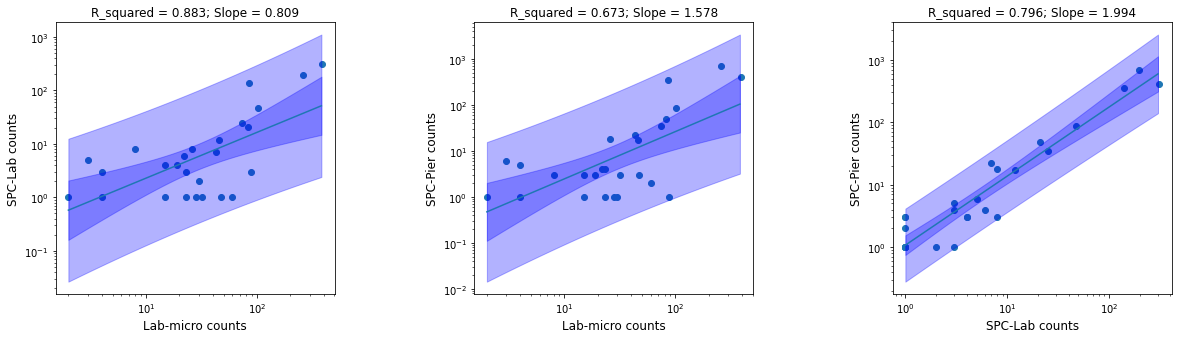

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     182.0
Date:                Mon, 26 Oct 2020   Prob (F-statistic):           1.07e-12
Time:                        20:12:18   Log-Likelihood:                -119.97
No. Observations:                  26   AIC:                             243.9
Df Residuals:                      24   BIC:                             246.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.5378      6.103     -2.710      0.0

In [7]:
import pandas as pd
from counts_analysis.c_utils import *
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as stats
import statsmodels.api as sm
import sklearn.metrics as metrics

df = pd.read_csv(COUNTS_CSV['counts-v10'])
df_l = []
classes = ['Akashiwo',
           'Ceratium falcatiforme or fusus',
           'Ceratium furca',
           'Chattonella',
           'Cochlodinium',
           'Lingulodinium polyedra',
           'Prorocentrum micans',
           'Pseudo-nitzschia chain'
           ]
for i in classes:
    temp = df.loc[df['class'] == i]
    df_l.append(temp)

def plot_scatter (ax, x,y, epsilon = 0, confidence = 0.95):
    #Get r2 and MAE
    p, cov = np.polyfit(x, y, 1, cov=True)
    y_model = np.polyval(p, x)
    resid = y - y_model
    rmsd = round(np.sqrt(np.sum(resid**2) / 24), 3)
    r2= round(metrics.r2_score(y, y_model), 3)
    slope = round(p[0], 3)
    
    if epsilon == 0:
        x = np.array( [np.log10(i) if i !=0 else 0 for i in x] )
        y = np.array( [np.log10(i) if i !=0 else 0 for i in y] ) 
    else:
        x = np.log10(x+epsilon)
        y = np.log10(y+epsilon)
    heights = x
    weights = y

    p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
    y_model = np.polyval(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

    # Statistics
    n = weights.size                                           # number of observations
    m = p.size                                                 # number of parameters
    dof = n - m                                                # degrees of freedom
    t = stats.t.ppf((1 + confidence) / 2., n - m)              # used for CI and PI bands

    # Estimates of Error in Data/Model
    resid = y - y_model                           
    chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
    chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
    s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error
    
    x2 = np.arange(np.min(x), np.max(x), 0.01)
    y2 = np.polyval(p, x2)
    
    def p10 (x):
        return np.power(10,x)
    
    #scatter plot
    ax.scatter(p10(x),p10(y))
    
    #best fitted line
    ax.plot( p10(x2), p10(y2) )
    
    #confidence band
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    
    ax.fill_between(p10(x2), p10(y2 + ci), p10(y2 - ci), alpha = 0.3, color='blue')
    
    # Prediction band
    pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
    ax.fill_between(p10(x2), p10(y2 + pi), p10(y2 - pi), alpha = 0.3, color='blue')

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_title('R_squared = {}; Slope = {}'.format(str(r2), str(slope)))

def get_np (df, str_):
    return np.array(df[str_].tolist())

def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    resid = y_true - y_pred
    rmsd = round(np.sqrt(np.sum(resid**2) / 24), 4)

    print('Explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSD: ', round(rmsd,4))
    
def plot_three_scatter (index, epsilon = 0, confidence = 0.95, save = False):
    plt.figure()
    fig, axes = plt.subplots(1, 3, figsize = (20,5))
    plt.subplots_adjust(wspace = 0.5)
    df_micro = get_np(df_l[index], 'micro raw count')
    df_lab = get_np(df_l[index], 'lab gtruth raw count')
    df_pier = get_np(df_l[index], 'pier gtruth raw count')
    
    plot_scatter( axes[0], df_micro, df_lab, epsilon = epsilon, confidence = confidence )
    axes[0].set_xlabel('Lab-micro counts', fontsize = 12)
    axes[0].set_ylabel('SPC-Lab counts', fontsize = 12)
    
    plot_scatter( axes[1], df_micro, df_pier, epsilon = epsilon, confidence = confidence )
    axes[1].set_xlabel('Lab-micro counts', fontsize = 12)
    axes[1].set_ylabel('SPC-Pier counts', fontsize = 12)
    
    plot_scatter( axes[2], df_lab, df_pier, epsilon = epsilon, confidence = confidence )
    axes[2].set_xlabel('SPC-Lab counts', fontsize = 12)
    axes[2].set_ylabel('SPC-Pier counts', fontsize = 12)
    
    if save:
        plt.savefig('./{}_3_scatter.png'.format(classes[index]), dpi = 800)
    plt.show()
    
def get_linear_fit_report (x, y):
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    res = model.fit()
    print(res.summary())  
    print('')
    p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
    y_model = np.polyval(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients
    regression_results(y, y_model)

    
# class name
cls_ = 'Prorocentrum micans'
df_cls = df_l[classes.index(cls_)]
plot_three_scatter( classes.index(cls_), save = True )

get_linear_fit_report( get_np(df_cls, 'micro raw count'), get_np(df_cls, 'lab gtruth raw count')  )



Akashiwo


<Figure size 432x288 with 0 Axes>

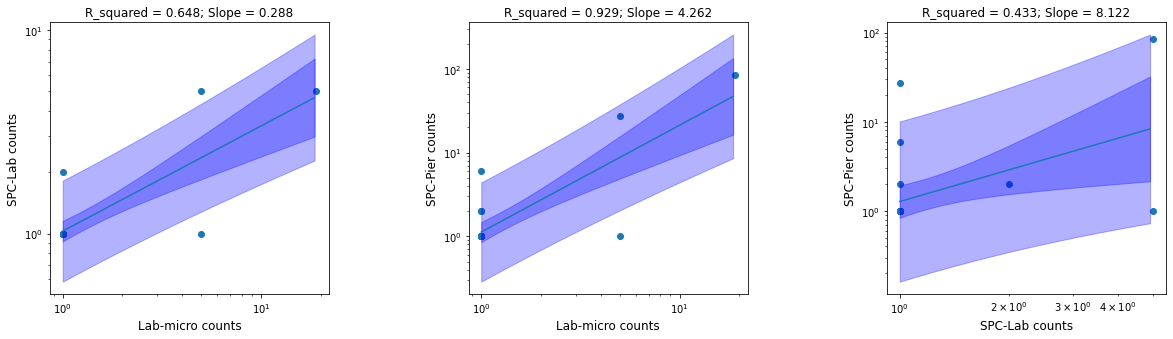

Ceratium falcatiforme or fusus


<Figure size 432x288 with 0 Axes>

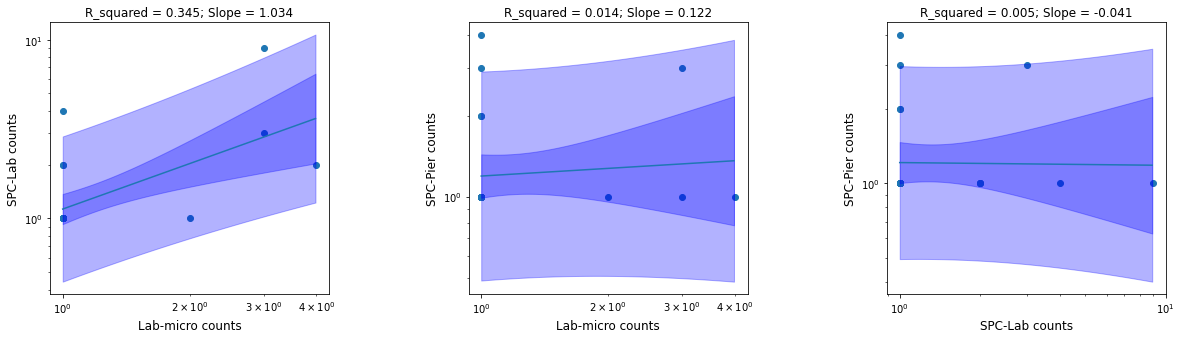

Ceratium furca


<Figure size 432x288 with 0 Axes>

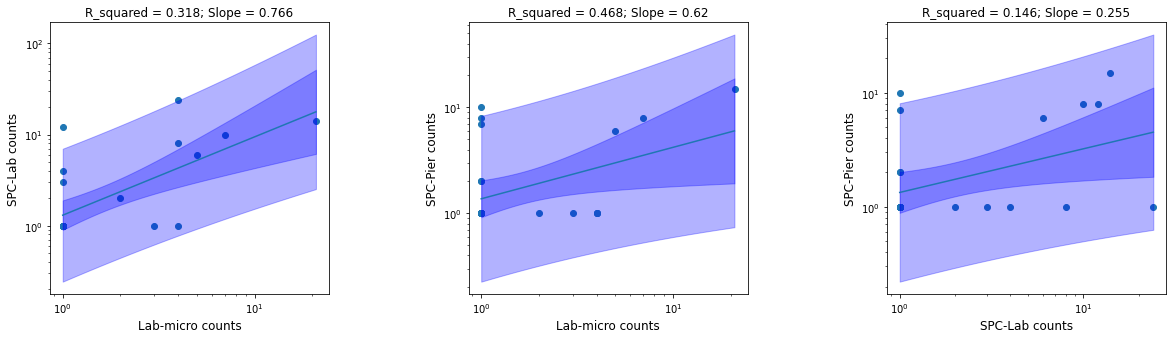

Chattonella


<Figure size 432x288 with 0 Axes>

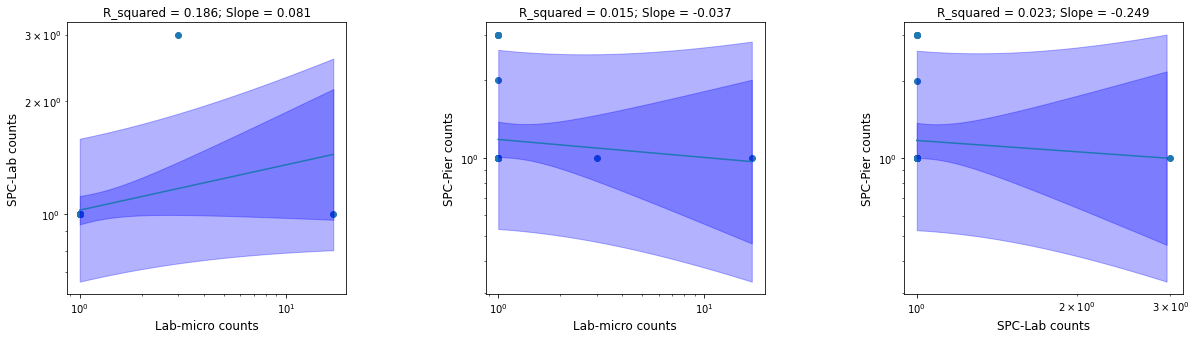

Cochlodinium


<Figure size 432x288 with 0 Axes>

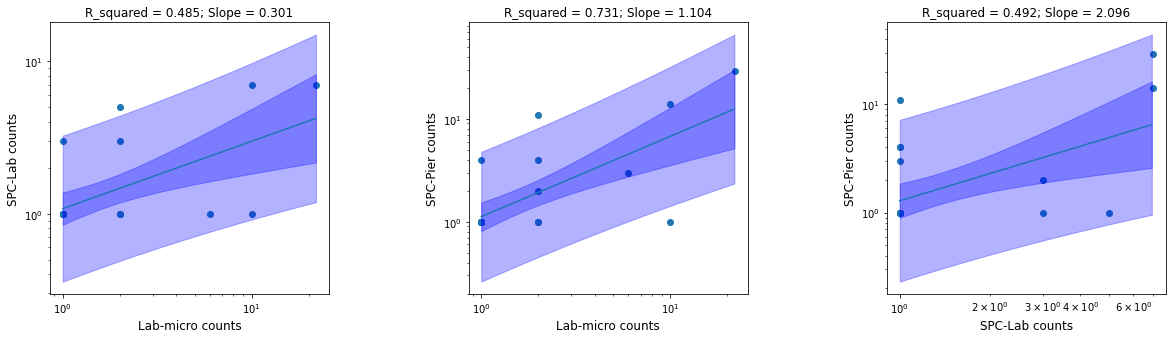

Lingulodinium polyedra


<Figure size 432x288 with 0 Axes>

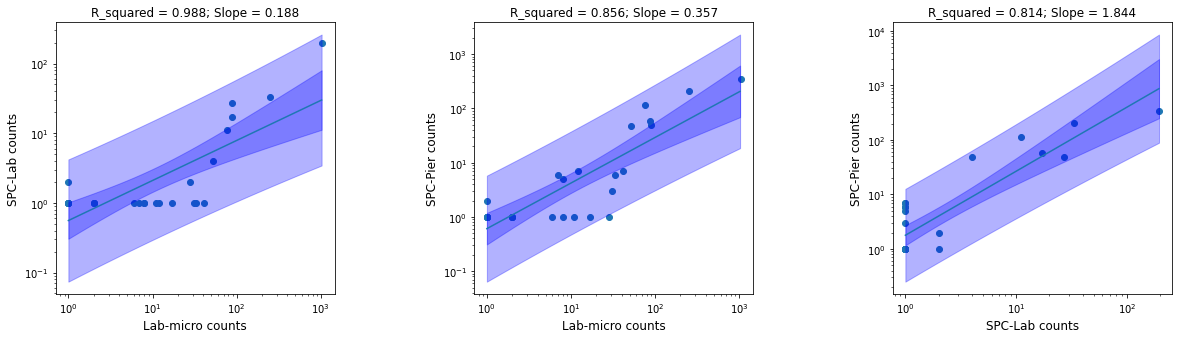

Prorocentrum micans


<Figure size 432x288 with 0 Axes>

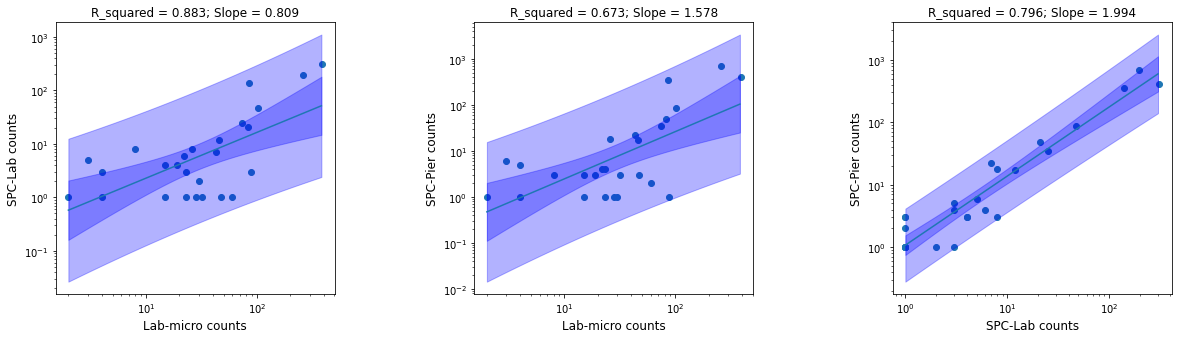

Pseudo-nitzschia chain


<Figure size 432x288 with 0 Axes>

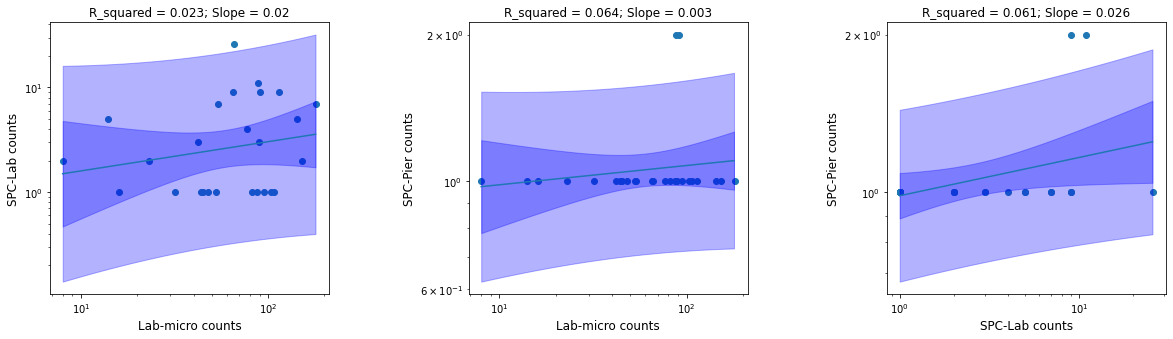

In [8]:
for cls_ in classes:
    print(cls_)
    df_cls = df_l[classes.index(cls_)]
    plot_three_scatter( classes.index(cls_), save = True )
    